# Imports

In [1]:
import os
import cv2
import torch
import time
import numpy as np
import pandas as pd
from PIL import Image
import torch.nn as nn
from tqdm import tqdm
import seaborn as sns
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from collections import Counter
from torch.utils.data import Subset
from torchvision import datasets, transforms 
from torch.utils.data import DataLoader, Subset, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Utils

In [2]:
# Setting up file paths
train_path = '/kaggle/input/kermany2018/OCT2017 /train'
test_path = '/kaggle/input/kermany2018/OCT2017 /test'
val_path = '/kaggle/input/kermany2018/OCT2017 /val'

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
def show_image_and_histogram(img, title_image="Image", title_hist="Histogram", bins=256):
    # plotar imagem de um lado e do outro o histograma
    plt.figure(figsize=(15, 5))

    # Adicionar a imagem
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap="gray")
    plt.title(title_image)
    plt.axis("off")

    # Adicionar o histograma da imagem
    plt.subplot(1, 2, 2)
    plt.hist(np.array(img).ravel(), bins=bins, color="black")
    plt.title(title_hist)
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()

In [5]:
def denormalize(img, mean, std):
    img = img * std + mean
    img = np.clip(img, 0, 1)
    return img

# Load Data

In [6]:
data_directory = train_path # No artigo, o autor utiliza apenas o diretório de treino para fazer o split em treino, teste e validação

In [7]:
split_train, split_val, split_test = 0.9016, 0.0184, 0.08
split_data = [split_train, split_val, split_test]
batch_size = 84

In [8]:
raw_dataset = datasets.ImageFolder(root=data_directory)

In [9]:
raw_dataset

Dataset ImageFolder
    Number of datapoints: 83484
    Root location: /kaggle/input/kermany2018/OCT2017 /train

# Preprocessing data

Etapas para pré-processamento de dados:

1. Leia os arquivos do diretório.

2. Aplique o redimensionamento de cada imagem para 150 × 150 pixels.

3. Aplique a operação CentreCrop com dimensões finais de 128 × 128 pixels a cada imagem.

4. Converta a imagem no tipo de dados tensor para compatibilidade com o modelo.

5. Normalize a imagem subtraindo a média de cada valor de pixel e dividindo o resultado pelo desvio padrão usando a transformação padrão.rmação padrão.



A normalização padrão ajuda a melhorar a convergência durante o treinamento de modelos de aprendizado de máquina, pois evita que a magnitude das variáveis tenha um impacto desproporcional na aprendizagem. Isso é especialmente importante em redes neurais, onde a uniformidade dos dados pode acelerar o treinamento e melhorar a precisão do modelo.

In [10]:
mean, std = 0.18484567, 0.15903676
resize = (150, 150)
center_crop = (128, 128)

In [11]:
input_channels = 3 # quantidade de canais presentes na imagem

In [12]:
transform = transforms.Compose([
    transforms.Resize(resize),
    transforms.CenterCrop(center_crop),
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean, mean, mean] , std=[std, std, std])
])

In [13]:
dataset = datasets.ImageFolder(root=data_directory, transform=transform)

In [14]:
train_dataset, val_dataset, test_dataset = random_split(dataset, split_data)

In [15]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## Enhancement

Etapas para aprimoramento de imagem:

1. Leia os arquivos do diretório.

2. Aplique filtro de desfoque da mediana para suavizar.

3. Converta em tons de cinza para operações futuras.

4. Aplique CLAHE sobre a imagem para melhorar o baixo contraste.

5. Limite de imagem por limites de corte de limite adequados.

6. Remova mais ruídos e quebras na estrutura por operação de morfologia.

7. Extraia os contornos da saída acima para extrair as bordas da camada retiniana (as outras técnicas de detecção de bordas não foram úteis conforme discutido).

8. Desenhe contornos na imagem original para permitir bordas e estruturas de camadas.

9. Aplique outras transformações como na etapa anterior, incluindo redimensionamento, corte central e normalização.e central e normalização.



In [16]:
def enhance_image(img, morphology_algorithm = cv2.MORPH_CLOSE ):
    img = np.array(img)
    original_img = img.copy()

    # Converter para tons de cinza, se necessário
    if len(img.shape) == 3 and img.shape[2] == 3:  
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Aplicar o filtro de mediana
    img = cv2.medianBlur(img, 5)

    # Aplicar CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img = clahe.apply(img)

    # Segmentar a imagem com o threshold de Otsu
    _, img_bin = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Remover ruídos com operação de morfológica
    # kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    img_bin = cv2.morphologyEx(img_bin, morphology_algorithm, kernel, iterations=1)

    # Extrair contornos
    contours, _ = cv2.findContours(img_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

     # Criar uma máscara binária a partir dos contornos
    mask = np.zeros_like(img_bin)
    cv2.drawContours(mask, contours, -1, 255, thickness=cv2.FILLED)  # Preencher os contornos

    # Multiplicar a imagem original pela máscara binária
    if len(original_img.shape) == 3:  # Se a imagem original for colorida
        mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)  # Converter a máscara para RGB
        enhanced_img = cv2.bitwise_and(original_img, mask)  # Aplicar a máscara
    else:
        enhanced_img = cv2.bitwise_and(original_img, mask)  # Aplicar a máscara (imagem em tons de cinza)
    
    # Converter o array numpy de volta para um objeto PIL.Image
    return Image.fromarray(enhanced_img)


enhancement_transform  = transforms.Compose([
    transforms.Lambda(lambda x: enhance_image(x, morphology_algorithm = cv2.MORPH_CLOSE)),
    
    transforms.Resize(resize),
    transforms.CenterCrop(center_crop),
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean],  std=[std])
])


In [17]:
enhanced_dataset = datasets.ImageFolder(root=data_directory, transform=enhancement_transform)

In [18]:
enhanced_train_dataset, enhanced_val_dataset, enhanced_test_dataset = random_split(enhanced_dataset, split_data)

In [19]:
enhanced_train_loader = DataLoader(enhanced_train_dataset, batch_size=batch_size, shuffle=True)
enhanced_test_loader = DataLoader(enhanced_test_dataset, batch_size=batch_size, shuffle=False)
enhanced_val_loader = DataLoader(enhanced_val_dataset, batch_size=batch_size, shuffle=False)

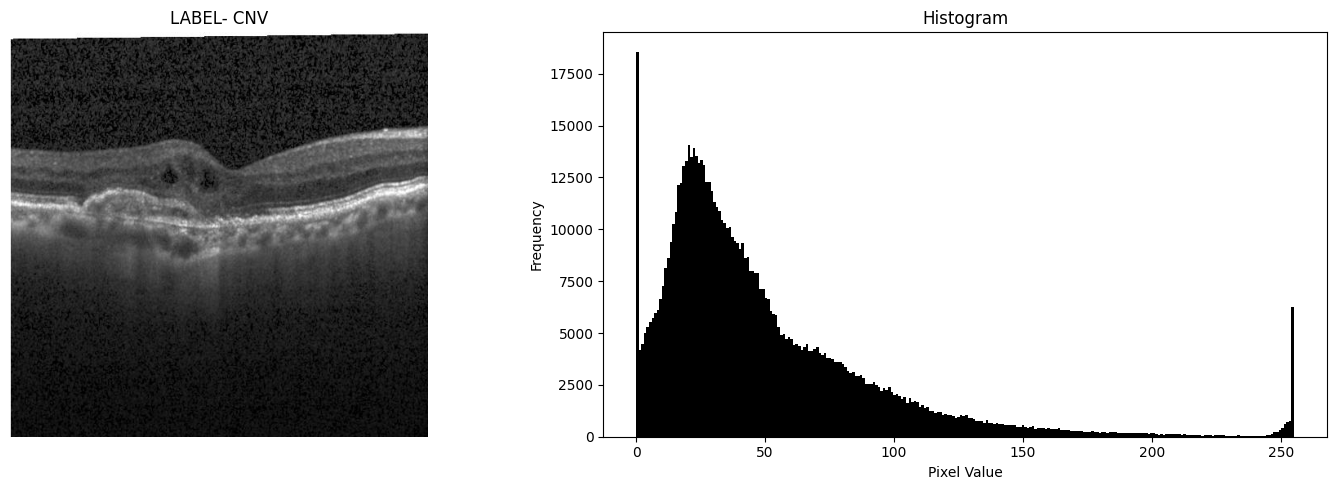

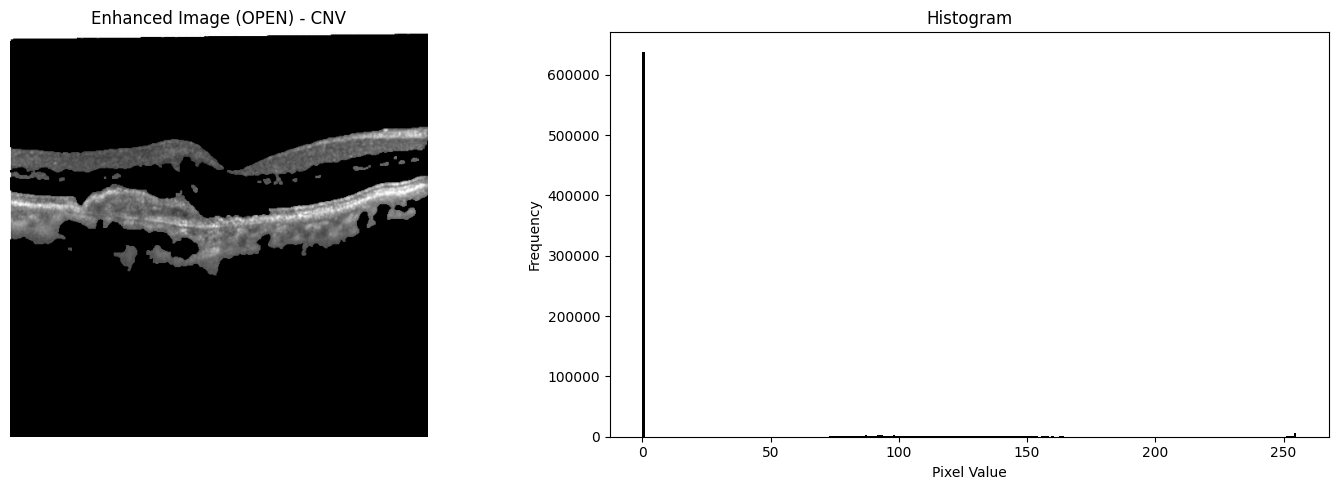

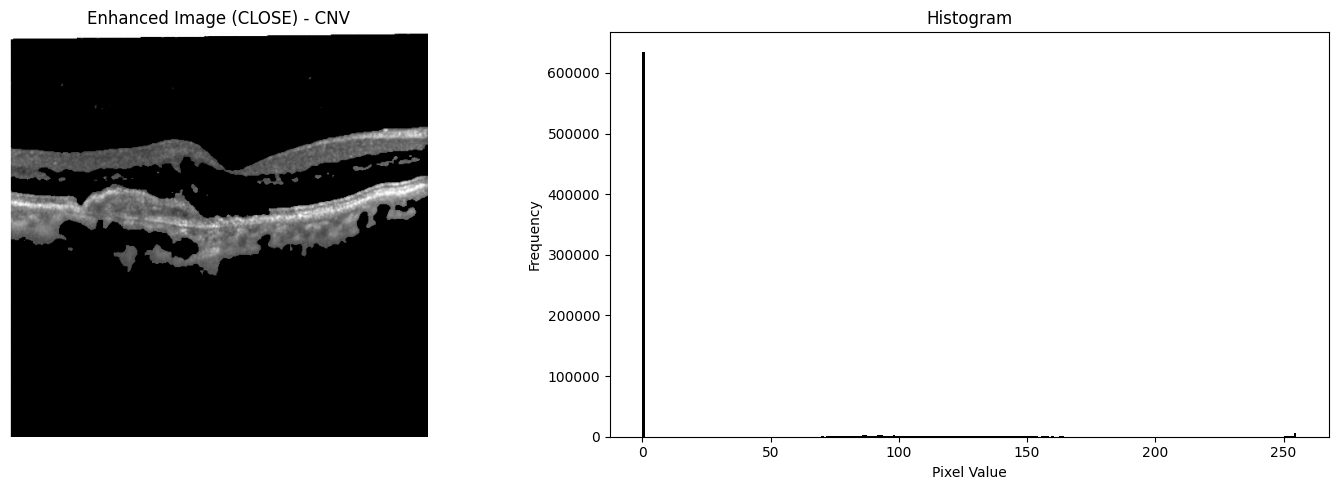

In [20]:
idx = 55
img, label = raw_dataset[idx]
show_image_and_histogram(img, f"LABEL- {raw_dataset.classes[label]}")
show_image_and_histogram(enhance_image(img, morphology_algorithm = cv2.MORPH_OPEN), f"Enhanced Image (OPEN) - {raw_dataset.classes[label]}")
show_image_and_histogram(enhance_image(img, morphology_algorithm = cv2.MORPH_CLOSE), f"Enhanced Image (CLOSE) - {raw_dataset.classes[label]}")

In [21]:
enhanced_img = enhance_image(img, morphology_algorithm = cv2.MORPH_OPEN)
enhanced_img = np.array(enhanced_img)
t = cv2.cvtColor(enhanced_img, cv2.COLOR_RGB2GRAY) if enhanced_img.ndim == 3 else enhanced_img
_, binary_img = cv2.threshold(t, 127, 255, cv2.THRESH_BINARY)
num_components, labels = cv2.connectedComponents(binary_img)

print(f"Number of connected components: {num_components - 1}")  # Subtract 1 to exclude the background (label 0)


Number of connected components: 95


In [22]:
enhanced_img = enhance_image(img, morphology_algorithm = cv2.MORPH_CLOSE)
enhanced_img = np.array(enhanced_img)
t = cv2.cvtColor(enhanced_img, cv2.COLOR_RGB2GRAY) if enhanced_img.ndim == 3 else enhanced_img
_, binary_img = cv2.threshold(t, 127, 255, cv2.THRESH_BINARY)
num_components, labels = cv2.connectedComponents(binary_img)

print(f"Number of connected components: {num_components - 1}")  # Subtract 1 to exclude the background (label 0)


Number of connected components: 92


### Problemas observados:


### Melhorias propostas para o aprimoramento:
- Não aplicar a maskara diretamente na original, e sim na original convertida em escala de cinza. Todos os 3 canais das imagens têm a mesma informação, são imagens RGB em tons de cinza.
- Utilizar um elemento estruturante elíptico(arredondado)

# Convolutional Neural Network Architectures

## Architectures

In [23]:
class CNN5(nn.Module):
    def __init__(self, input_channels, image_size = (128, 128)):
        super(CNN5, self).__init__()
        
        self.n = 4 # número de operacoes de pooling

        # calcular resolução final baseada no image_size
        self.height, self.width = image_size
        self.final_height = self.height // (2 ** self.n)
        self.final_width = self.width // (2 ** self.n)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) 

        self.conv1_1 = nn.Conv2d(in_channels=input_channels, out_channels=16, kernel_size=3, padding=1)
        
        self.conv2_1 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        
        self.conv3_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(in_channels=32, out_channels=48, kernel_size=3, padding=1)
        
        self.conv4_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, padding=1)

        self.flattened_input_size = 48 * self.final_height * self.final_width
        self.fc1 = nn.Linear(self.flattened_input_size, 1536)
        self.fc2 = nn.Linear(1536, 512)
        self.fc3 = nn.Linear(512, 4)  

        self.dropout = nn.Dropout(p=0.4)

    def forward(self, x):
        x = F.relu(self.conv1_1(x))
        x = self.pool(x)
        
        x = F.relu(self.conv2_1(x))
        x = self.pool(x) 
        
        x = F.relu(self.conv3_1(x))          
        x = F.relu(self.conv3_2(x))
        x = self.pool(x)  
        
        x = F.relu(self.conv4_1(x))
        x = self.pool(x) 
        
        x = x.view(-1, self.flattened_input_size)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc3(x))
        
        x = F.log_softmax(x, dim=1)
        return x


In [24]:
class CNN7(nn.Module):
    def __init__(self, input_channels, image_size = (128, 128)):
        super(CNN7, self).__init__()
        
        self.n = 4 # número de operacoes de pooling

        # calcular resolução final baseada no image_size
        self.height, self.width = image_size
        self.final_height = self.height // (2 ** self.n)
        self.final_width = self.width // (2 ** self.n)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv1_1 = nn.Conv2d(in_channels=input_channels, out_channels=16, kernel_size=3, padding=1)
        
        self.conv2_1 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        
        self.conv3_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(in_channels=32, out_channels=48, kernel_size=3, padding=1)
        
        self.conv4_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, padding=1)

        self.flattened_input_size = 48 * self.final_height * self.final_width
        self.fc1 = nn.Linear(self.flattened_input_size, 1536)  
        self.fc2 = nn.Linear(1536, 512)
        self.fc3 = nn.Linear(512, 4) 

        self.dropout = nn.Dropout(p=0.4)
        
    def forward(self, x):
        x = F.relu(self.conv1_1(x))
        x = self.pool(x) 
        
        x = F.relu(self.conv2_1(x))        
        x = F.relu(self.conv2_2(x))
        x = self.pool(x)  
        
        x = F.relu(self.conv3_1(x))          
        x = F.relu(self.conv3_2(x))           
        x = F.relu(self.conv3_3(x))   
        x = self.pool(x)   
        
        x = F.relu(self.conv4_1(x))
        x = self.pool(x)   
        
        x = x.view(-1, self.flattened_input_size)
        x = F.relu(self.fc1(x))       
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.log_softmax(self.fc3(x), dim=1)
        # TODO: nao aplicar a relu antes de passar para o log_softmax
        
        return x



In [25]:
class CNN9(nn.Module):
    def __init__(self, input_channels, image_size = (128, 128)):
        super(CNN9, self).__init__()
        
        self.n = 4 # número de operacoes de pooling

        # calcular resolução final baseada no image_size
        self.height, self.width = image_size
        self.final_height = self.height // (2 ** self.n)
        self.final_width = self.width // (2 ** self.n)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv1_1 = nn.Conv2d(in_channels=input_channels, out_channels=16, kernel_size=3, padding=1)
        
        self.conv2_1 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        
        self.conv3_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(in_channels=32, out_channels=48, kernel_size=3, padding=1)
        
        self.conv4_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(in_channels=48, out_channels=64, kernel_size=3, padding=1)

        self.flattened_input_size = 64 * self.final_height * self.final_width
        self.fc1 = nn.Linear(64 * self.final_height * self.final_width, 512) 
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 4)
        
        self.dropout = nn.Dropout(p=0.4)
        
    def forward(self, x):
        x = F.relu(self.conv1_1(x))
        x = self.pool(x) 
        
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = self.pool(x)
        
        x = F.relu(self.conv3_1(x))          
        x = F.relu(self.conv3_2(x))
        x = F.relu(self.conv3_3(x))
        x = self.pool(x) 
        
        x = F.relu(self.conv4_1(x)) 
        x = F.relu(self.conv4_2(x))
        x = F.relu(self.conv4_3(x))
        x = self.pool(x)
        
        x = x.view(-1, self.flattened_input_size)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)    
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        
        x = F.log_softmax(x, dim=1)
        return x

## Initializing CNNs

In [26]:
# Hiperparâmetros
learning_rate = 0.001

# config
epochs = 10
# epochs = 10 if device != "cpu" else 1

In [27]:
model_cnn5 = CNN5(input_channels=input_channels).to(device) 
criterion_cnn5 = nn.NLLLoss()
optimizer_cnn5 = optim.Adam(model_cnn5.parameters(), lr=learning_rate)
model_cnn5

CNN5(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1_1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_1): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3072, out_features=1536, bias=True)
  (fc2): Linear(in_features=1536, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=4, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)

In [28]:
model_cnn7 = CNN7(input_channels=input_channels).to(device) 
criterion_cnn7 = nn.NLLLoss()
optimizer_cnn7 = optim.Adam(model_cnn7.parameters(), lr=learning_rate)
model_cnn7

CNN7(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1_1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_3): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_1): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3072, out_features=1536, bias=True)
  (fc2): Linear(in_features=1536, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=4, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)

In [29]:
model_cnn9 = CNN9(input_channels=input_channels).to(device) 
criterion_cnn9 = nn.NLLLoss()
optimizer_cnn9 = optim.Adam(model_cnn9.parameters(), lr=learning_rate)
model_cnn9

CNN9(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1_1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_3): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_1): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_2): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_3): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=4, bias=True)
  (dropout): D

In [30]:
model_cnn7_enhanced = CNN7(input_channels=input_channels).to(device) 
criterion_cnn7_enhanced = nn.NLLLoss()
optimizer_cnn7_enhanced = optim.Adam(model_cnn7_enhanced.parameters(), lr=learning_rate)
model_cnn7_enhanced

CNN7(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1_1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_3): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_1): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3072, out_features=1536, bias=True)
  (fc2): Linear(in_features=1536, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=4, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)

## Treinamento

### Utils

In [31]:
def train(model, train_loader, epochs=10, optimizer=None, criterion=None ):
    model.train()  # Colocar o modelo em modo de treino
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}', leave=True):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()  # Zerar gradientes
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Calcular a perda
            
            loss.backward()  # Backward pass
            optimizer.step()  # Atualizar pesos
            running_loss += loss.item()
        avg_loss = running_loss / len(train_loader)  # Cálculo da perda média



In [32]:
# TODO: acumular o history do treinamento

### Train

In [33]:
# train(model_cnn5, train_loader, epochs=epochs, criterion=criterion_cnn5, optimizer=optimizer_cnn5)

In [34]:
train(model_cnn7, train_loader, epochs=epochs, optimizer=optimizer_cnn7, criterion=criterion_cnn7)

Epoch 10/10: 100%|██████████| 897/897 [07:11<00:00,  2.08it/s]


In [35]:
# train(model_cnn9, train_loader, epochs=epochs, optimizer=optimizer_cnn9, criterion=criterion_cnn9)

In [36]:
train(model_cnn7_enhanced, enhanced_train_loader, epochs=epochs, optimizer=optimizer_cnn7_enhanced, criterion=criterion_cnn7_enhanced)

Epoch 10/10: 100%|██████████| 897/897 [21:23<00:00,  1.43s/it]


## Validation

### Utils

In [37]:
def eval(model, test_loader): #TODO: precisa receber a função de perda
    model.eval()  # Coloca o modelo em modo de avaliação
    all_preds, all_labels = [], []
    with torch.no_grad():  # Desabilitar o cálculo de gradiente para economizar memória
        for inputs, labels in tqdm(test_loader, desc="Test Progress", leave=True):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)   
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy()) 
    return all_preds, all_labels

In [38]:
def calculate_metrics(cm, classes): 
    #TODO: CORRIGIR(ACCURACY ERRADA)
    metrics = {}
    
    # Para cada classe
    for i, class_name in enumerate(classes):
        TP = cm[i, i]
        FP = cm[:, i].sum() - TP  # Soma da coluna - TP
        FN = cm[i, :].sum() - TP  # Soma da linha - TP
        TN = cm.sum() - (TP + FP + FN)
    
        # accuracy = (TP + TN) / cm.sum()
        accuracy = (TP + TN) / (FP + FN + TP + TN)
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0 
        f1_score = (2 * TP) / (FP + FN + (2* TP)) if (FP + FN + (2* TP)) > 0 else 0
        
        metrics[class_name] = {
            "Acurácia": accuracy,
            "Precision": precision,
            "Sensitivity/Recall": sensitivity,
            "Specificity": specificity,
            "F1-Score": f1_score
        }
    
    return pd.DataFrame(metrics)

In [39]:
def evaluate_model(model, test_loader, eval_function, calculate_metrics_function, classes):
    # Avaliação do modelo
    all_preds, all_labels = eval_function(model, test_loader)

    # Matriz de Confusão
    cm = confusion_matrix(all_labels, all_preds)
    
    # Cálculo das métricas
    metrics = calculate_metrics_function(cm, classes)

    # return cm, metrics
    return {
        "all_preds": all_preds,
        "all_labels": all_labels,
        "cm": cm,
        "metrics": metrics,
    }

In [40]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, cohen_kappa_score

def calculate_metrics_per_class(y_true, y_pred, class_names=None):
    unique_classes = sorted(set(y_true))
    metrics_per_class = {}
    for idx, class_label in enumerate(unique_classes):
        precision = precision_score(y_true, y_pred, labels=[class_label], average='macro', zero_division=0)
        recall = recall_score(y_true, y_pred, labels=[class_label], average='macro', zero_division=0)    
        class_name = class_names[class_label] if class_names else class_label
        metrics_per_class[class_name] = {
            "precision": precision,
            "recall": recall,
        }
    return metrics_per_class

def calculate_overall_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    sensitivity = cm.diagonal() / cm.sum(axis=1)
    avg_sensitivity = sensitivity.mean()
    specificity = []
    for i in range(len(cm)):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        specificity.append(tn / (tn + fp) if (tn + fp) != 0 else 0)
    avg_specificity = sum(specificity) / len(specificity)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    kappa = cohen_kappa_score(y_true, y_pred)
    return {
        "accuracy": accuracy,
        "sensitivity": avg_sensitivity,
        "specificity": avg_specificity,
        "f1_score": f1,
        "kappa": kappa
    }

### Eval

In [41]:
# all_preds_cnn5, all_labels_cnn5 = eval(model_cnn5, test_loader)

In [42]:
all_preds_cnn7, all_labels_cnn7 = eval(model_cnn7, test_loader)

Test Progress: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]


In [43]:
# all_preds_cnn9, all_labels_cnn9 = eval(model_cnn9, test_loader)

In [44]:
all_preds_cnn7_enhanced, all_labels_cnn7_enhanced = eval(model_cnn7_enhanced, enhanced_test_loader)

Test Progress: 100%|██████████| 80/80 [01:52<00:00,  1.40s/it]


### Confusion Matrix

In [45]:
# cm_cnn5 = confusion_matrix(all_labels_cnn5, all_preds_cnn5)
# pd.DataFrame(cm_cnn5, index = dataset.classes, columns = dataset.classes)

In [46]:
cm_cnn7 = confusion_matrix(all_labels_cnn7, all_preds_cnn7)
pd.DataFrame(cm_cnn7, index = dataset.classes, columns = dataset.classes)

,CNV,DME,DRUSEN,NORMAL
CNV,2909,26,28,5
DME,23,816,3,27
DRUSEN,111,4,498,47
NORMAL,7,44,16,2114


In [47]:
# cm_cnn9 = confusion_matrix(all_labels_cnn9, all_preds_cnn9)
# pd.DataFrame(cm_cnn9, index = dataset.classes, columns = dataset.classes)

In [48]:
cm_cnn7_enhanced = confusion_matrix(all_labels_cnn7_enhanced, all_preds_cnn7_enhanced)
pd.DataFrame(cm_cnn7_enhanced, index = dataset.classes, columns = dataset.classes)

,CNV,DME,DRUSEN,NORMAL
CNV,2954,12,32,1
DME,48,732,5,96
DRUSEN,102,1,567,30
NORMAL,6,35,37,2020


### Metrics

In [49]:
# calculate_metrics(cm_cnn5, dataset.classes)

In [50]:
calculate_metrics(cm_cnn7, dataset.classes)

,CNV,DME,DRUSEN,NORMAL
Acurácia,0.970051,0.980982,0.968703,0.978137
Precision,0.953770,0.916854,0.913761,0.963976
Sensitivity/Recall,0.980121,0.939010,0.754545,0.969280
Specificity,0.961995,0.987261,0.992190,0.982433
F1-Score,0.966766,0.927800,0.826556,0.966621


In [51]:
# calculate_metrics(cm_cnn9, dataset.classes)

In [52]:
calculate_metrics(cm_cnn7_enhanced, dataset.classes)

,CNV,DME,DRUSEN,NORMAL
Acurácia,0.969901,0.970500,0.969003,0.969302
Precision,0.949839,0.938462,0.884555,0.940848
Sensitivity/Recall,0.984995,0.830874,0.810000,0.962822
Specificity,0.957597,0.991720,0.987621,0.972271
F1-Score,0.967098,0.881397,0.845638,0.951708


### Metrics(macro)

In [53]:
# metrics_macro_cnn5 = calculate_overall_metrics(y_true = all_labels_cnn5, y_pred = all_preds_cnn5)
# for metric in metrics_macro_cnn5:
#     print(f"{metric:20s}\t{metrics_macro_cnn5[metric] * 100:0.5f}%")

In [54]:
metrics_macro_cnn7 = calculate_overall_metrics(y_true = all_labels_cnn7, y_pred = all_preds_cnn7)
for metric in metrics_macro_cnn7:
    print(f"{metric:20s}\t{metrics_macro_cnn7[metric] * 100:0.2f}%")

accuracy            	94.89%
sensitivity         	91.07%
specificity         	98.10%
f1_score            	92.19%
kappa               	92.31%


In [55]:
# metrics_macro_cnn9 = calculate_overall_metrics(y_true = all_labels_cnn9, y_pred = all_preds_cnn9)
# for metric in metrics_macro_cnn9:
#     print(f"{metric:20s}\t{metrics_macro_cnn9[metric] * 100:0.2f}%")

In [56]:
metrics_macro_cnn7_enhanced = calculate_overall_metrics(y_true = all_labels_cnn7_enhanced, y_pred = all_preds_cnn7_enhanced)
for metric in metrics_macro_cnn7_enhanced:
    print(f"{metric:20s}\t{metrics_macro_cnn7_enhanced[metric] * 100:0.2f}%")

accuracy            	93.94%
sensitivity         	89.72%
specificity         	97.73%
f1_score            	91.15%
kappa               	90.87%


### Metrics(local)

In [57]:
# metrics_local_cnn5 = calculate_metrics_per_class(y_true=all_labels_cnn5, y_pred=all_preds_cnn5, class_names=dataset.classes)
# pd.DataFrame(metrics_local_cnn5)

In [58]:
metrics_local_cnn7 = calculate_metrics_per_class(y_true=all_labels_cnn7, y_pred=all_preds_cnn7, class_names=dataset.classes)
pd.DataFrame(metrics_local_cnn7)

,CNV,DME,DRUSEN,NORMAL
precision,0.953770,0.916854,0.913761,0.963976
recall,0.980121,0.939010,0.754545,0.969280


In [59]:
# metrics_local_cnn9 = calculate_metrics_per_class(y_true=all_labels_cnn9, y_pred=all_preds_cnn9, class_names=dataset.classes)
# pd.DataFrame(metrics_local_cnn9)

In [60]:
metrics_local_cnn7_enhanced = calculate_metrics_per_class(y_true=all_labels_cnn7_enhanced, y_pred=all_preds_cnn7_enhanced, class_names=dataset.classes)
pd.DataFrame(metrics_local_cnn7_enhanced)

,CNV,DME,DRUSEN,NORMAL
precision,0.949839,0.938462,0.884555,0.940848
recall,0.984995,0.830874,0.810000,0.962822
